# PLAsTiCC SNIa

In [1]:
import numpy as np

from tdastro import _TDASTRO_BASE_DATA_DIR
from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.astro_utils.pzflow_node import PZFlowNode
from tdastro.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
)
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.obstable.opsim import OpSim
from tdastro.simulate import simulate_lightcurves
from tdastro.models.sncomso_models import SncosmoWrapperModel
from tdastro.models.snia_host import SNIaHost
from tdastro.utils.plotting import plot_lightcurves

## Load Data Files

We start by loading the files we will need for running the simulation: the OpSim database and the passband information. Both of these live in the `data/` directory in the root directory. Note that nothing in this directory is saved to github, so the files might have to be downloaded initially.

For Rubin, a large number of OpSims can be found at [https://s3df.slac.stanford.edu/data/rubin/sim-data/](https://s3df.slac.stanford.edu/data/rubin/sim-data/). You can download an OpSim manually or using the `from_url()` helper function:

> opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"
> opsim_data = OpSim.from_url(opsim_url)

In [2]:
OPSIM_DB_PATH = "/Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/opsim/baseline_v5.0.0_10yrs.db"  # Path to your downloaded OpSim database

In [3]:
# Load the OpSim data.
opsim_db = OpSim.from_db(OPSIM_DB_PATH)

t_min, t_max = opsim_db.time_bounds()
print(f"Loaded OpSim with {len(opsim_db)} rows and times [{t_min}, {t_max}]")

# Load the passband data for the griz filters only.
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    filters=["g", "r", "i", "z"],
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
)
print(f"Loaded Passbands: {passband_group}")

2025-09-09 17:30:05,580 - INFO - Loading passbands from preset LSST
2025-09-09 17:30:05,590 - INFO - Data file /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/u.dat already exists. Skipping download.
2025-09-09 17:30:05,590 - INFO - Loading passband from file: /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/u.dat
2025-09-09 17:30:05,598 - INFO - Data file /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/g.dat already exists. Skipping download.
2025-09-09 17:30:05,599 - INFO - Loading passband from file: /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/g.dat
2025-09-09 17:30:05,605 - INFO - Data file /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/r.dat already exists. Skipping download.
2025-09-09 17:30:05,606 - INFO - Loading passband from file: /Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/passbands/LSST/r.dat
2025-09-09 17:30:05,610

Loaded OpSim with 2048612 rows and times [60980.00162606769, 64632.272916088485]
Loaded Passbands: PassbandGroup containing 4 passbands: LSST_g, LSST_r, LSST_i, LSST_z


We don't care about any of the observation in the OpSim that are not in one of the filters of interest. We can use a combination of `PassbandGroup`'s `mask_by_filter()` to determine which observations match and `OpSim`'s `filter_rows()` to remove those rows that do not match.

In [4]:
# Create a mask of matching filters.
filter_mask = passband_group.mask_by_filter(opsim_db["filter"])

# Filter the OpSim
opsim_db = opsim_db.filter_rows(filter_mask)
t_min, t_max = opsim_db.time_bounds()
print(f"Filtered OpSim to {len(opsim_db)} rows and times [{t_min}, {t_max}]")

Filtered OpSim to 1563870 rows and times [60980.00162606769, 64632.25331393084]


## Create the model

To generate simulationed lightcurves we need to define the proporties of the object from which to sample. We start by creating a host based on a pre-trained pzflow model.

In [5]:
# Load the Flow model into a PZFlow node. This gives access to all of the outputs of the
# flow model as attributes of the PZFlowNode.
pz_node = PZFlowNode.from_file(
    _TDASTRO_BASE_DATA_DIR / "model_files" / "snia_hosts_test_pzflow.pkl",  # filename
    node_label="pznode",
)

# Create a model for the host of the SNIa. The attributes will be sampled via
# the PZFlowNode's model. So each host instantiation will have its own properties.
# Note: This requires the user to know the output names from the underlying flow model.
host = SNIaHost(
    ra=pz_node.RA_GAL,
    dec=pz_node.DEC_GAL,
    hostmass=pz_node.LOGMASS,
    redshift=NumpyRandomFunc("uniform", low=0.1, high=0.6),
    node_label="host",
)

INFO:2025-09-09 17:30:07,535:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-09-09 17:30:07,535 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-09 17:30:07,539:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/site-packages/jaxlib/../../../libtpu.so' (no such file), '/Users/sidchaini/miniconda3/envs/tdastro/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-09-09 17:30:07,539 - INFO - Unable to initialize backend 'tpu': INTERN

Next we create the SNIa model itself. We use sncomso's SALT2 model with parameters randomly generated from realistic distributions.

Note that some attributes, such as (RA, dec), are sampled relative to the host's properties.

In [6]:
distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
x1_func = HostmassX1Func(host.hostmass)
c_func = NumpyRandomFunc("normal", loc=0, scale=0.02)
m_abs_func = NumpyRandomFunc("normal", loc=-19.3, scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=x1_func,
    c=c_func,
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt2-h17"
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=x1_func,
    c=c_func,
    ra=NumpyRandomFunc("normal", loc=host.ra, scale=0.01),
    dec=NumpyRandomFunc("normal", loc=host.dec, scale=0.01),
    redshift=host.redshift,
    node_label="source",
)

## Generate the simulations

We can now generate random simulations with all the information defined above. The light curves are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. 

In [7]:
lightcurves = simulate_lightcurves(source, 1_000, opsim_db, passband_group, time_window_offset=(-30,70))
print(lightcurves)

      id         ra        dec  nobs         z  \
0      0  55.346104 -43.187587     0  0.561956   
1      1  55.133758 -43.357337    14  0.299201   
..   ...        ...        ...   ...       ...   
998  998  55.281624 -43.205497     5  0.211446   
999  999  55.134281 -43.338373     6  0.153598   

                                                params  \
0    {'pznode.RA_GAL': 55.351574, 'pznode.DEC_GAL':...   
1    {'pznode.RA_GAL': 55.13494, 'pznode.DEC_GAL': ...   
..                                                 ...   
998  {'pznode.RA_GAL': 55.28195, 'pznode.DEC_GAL': ...   
999  {'pznode.RA_GAL': 55.125534, 'pznode.DEC_GAL':...   

                                            lightcurve  
0                                                 None  
1    [{mjd: 62489.040285, filter: 'z', flux: 8628.7...  
..                                                 ...  
998  [{mjd: 61454.02357, filter: 'i', flux: 13192.6...  
999  [{mjd: 63144.369221, filter: 'r', flux: 16352....  

[1000 r

In [62]:
model.evaluate_bandfluxes(
    passbands[survey_idx], obs_times, obs_filters, state
)


In [18]:
# # Dictionary to hold the new, perfectly-sampled light curves
# perfect_lightcurves = {}

# # The filters you want in your perfect light curve
# filters_to_evaluate = ["g", "r", "i", "z"]

# # Loop through each of the 1,000 supernovae you already simulated
# for i, row in lightcurves.iterrows():
#     # Get the sampled parameters for this specific supernova
#     state_dict = row["params"]
    
#     # We need to reconstruct a State object from the dictionary for the model
#     # Note: Depending on the complexity of the model, you might need to
#     # re-sample or reconstruct the state in a more detailed way.
#     # For many models, passing the dictionary of parameters may be sufficient
#     # if the model can resolve it. A robust way is to re-evaluate the model graph
#     # with the specific parameter values.
#     # However, for this salt2 model, we can directly access t0.
#     t0 = state_dict['source.t0']

#     # 1. Define the "perfect" time sampling
#     # Let's create a daily grid from 50 days before t0 to 150 days after
#     perfect_times = np.arange(t0 - 50, t0 + 150, 1.0)
    
#     perfect_obs = []
#     # 2. Evaluate the model at these times for each filter
#     for band in filters_to_evaluate:
#         # Create an array of the same filter for each time
#         # perfect_filters = np.full_like(perfect_times, band)
#         perfect_filters = np.full(perfect_times.shape, band)

        
#         # Calculate the perfect, noise-free bandflux
#         # We pass the state_dict as the 'state'
#         bandfluxes_perfect = source.evaluate_bandfluxes(
#             passband_group, perfect_times, perfect_filters, state_dict
#         )
        
#         # Store the results for this band
#         for t, f in zip(perfect_times, bandfluxes_perfect):
#             perfect_obs.append({'mjd': t, 'filter': band, 'flux_perfect': f})
            
#     # Store all observations for this object
#     perfect_lightcurves[i] = pd.DataFrame(perfect_obs)

# # You now have a dictionary `perfect_lightcurves` where each key is the object's
# # original index and the value is a DataFrame with its perfectly sampled light curve.

# # Example: Print the perfect light curve for the first object
# print("\nPerfectly-sampled light curve for object 0:")
# print(perfect_lightcurves[0])

In [45]:
# --- Continuation from your script ---

import pandas as pd
import numpy as np
import sncosmo  # <-- Import the sncosmo library

# Dictionary to hold the new, perfectly-sampled light curves
perfect_lightcurves = {}

# The filters you want in your perfect light curve
filters_to_evaluate = ["g", "r", "i", "z"]

# The sncosmo model name used when creating the tdastro source
# This must match what you defined earlier.
sncosmo_modelname = "salt2-h17"

# Loop through each of the 1,000 supernovae you already simulated
for i, row in lightcurves.iterrows():
    state_dict = row["params"]

    model = sncosmo.Model(source=sncosmo_modelname)
    sncosmo_params = {
        'z':state_dict['source.redshift'],
        't0':state_dict['source.t0'],
        'x0':state_dict['source.x0'],
        'x1':state_dict['source.x1'],
        'c':state_dict['source.c'],
    }
    model.set(**sncosmo_params)

    break
    # 4. Define the "perfect" time sampling grid
    perfect_times = np.arange(t0 - 50, t0 + 150, 1.0)
    
    perfect_obs = []
    # 5. Evaluate the sncosmo model at these times for each filter
    for band in filters_to_evaluate:
        # Get the sncosmo.Bandpass object from the tdastro PassbandGroup
        # sncosmo needs the actual bandpass data to calculate the flux.
        # passband_obj = passband_group.get_passband(band)
        passband_obj = passband_group.passbands.keys()

        # Calculate the perfect, noise-free flux using the sncosmo model.
        # We pass the absolute MJD times; the model uses its 't0' parameter internally.
        bandfluxes_perfect = model.bandflux(
            passband_obj,
            perfect_times,
            zp=passband_group.zeropoint,
            zpsys='ab'
        )
        
        # Store the results for this band
        for t, f in zip(perfect_times, bandfluxes_perfect):
            perfect_obs.append({'mjd': t, 'filter': band, 'flux_perfect': f})
            
    # Store all observations for this object in a DataFrame
    perfect_lightcurves[i] = pd.DataFrame(perfect_obs)

# You now have the final dictionary `perfect_lightcurves`

In [ ]:

# Example: Print the perfect light curve for the first object
print("\nPerfectly-sampled light curve for object 0:")
print(perfect_lightcurves[0].head())

# Example: Plot the result to verify
import matplotlib.pyplot as plt

first_lc = perfect_lightcurves[0]
for band in filters_to_evaluate:
    band_df = first_lc[first_lc['filter'] == band]
    plt.plot(band_df['mjd'], band_df['flux_perfect'], marker='.', linestyle='-', label=f'Filter {band}')

plt.xlabel("MJD")
plt.ylabel("Perfect Flux")
plt.title("Perfectly Sampled Light Curve for Object 0")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
!pip uninstall tdastro --y

Found existing installation: tdastro 0.0.7
Uninstalling tdastro-0.0.7:
  Successfully uninstalled tdastro-0.0.7


Now let's plot some random light curves

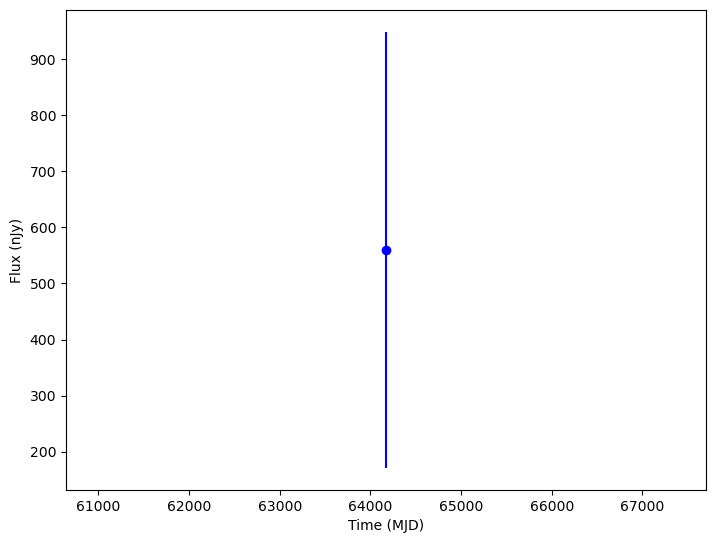

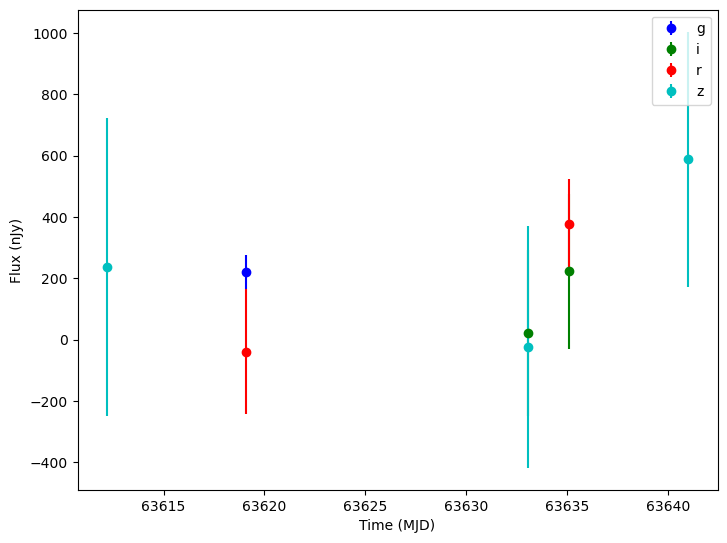

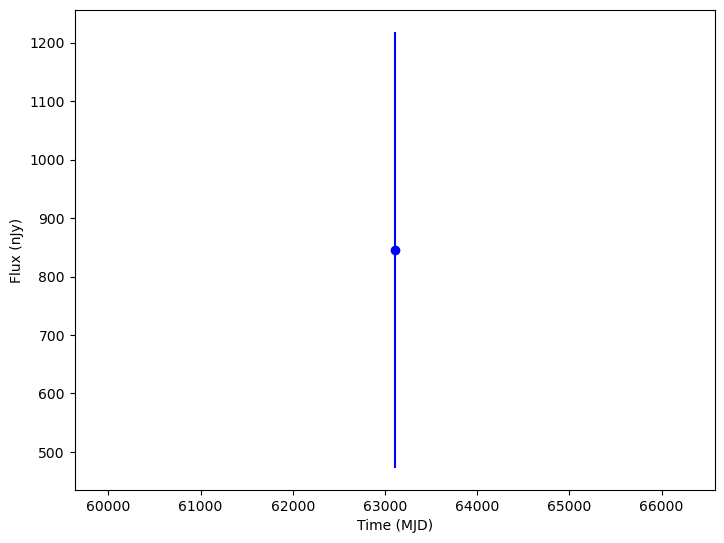

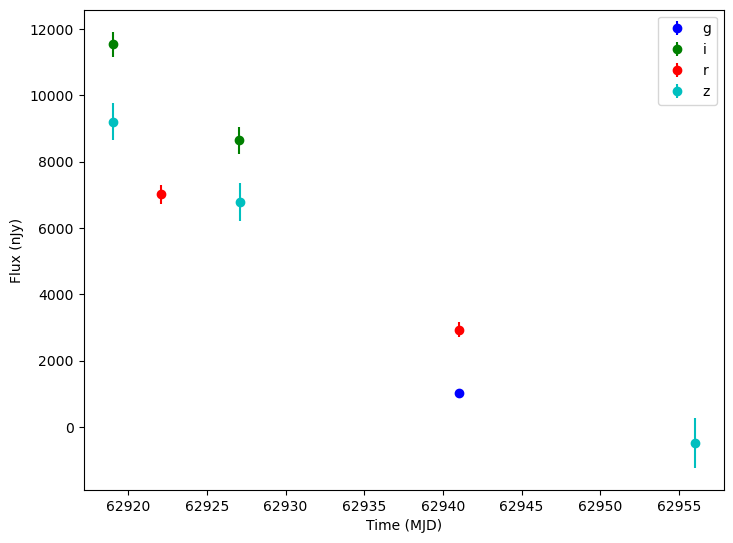

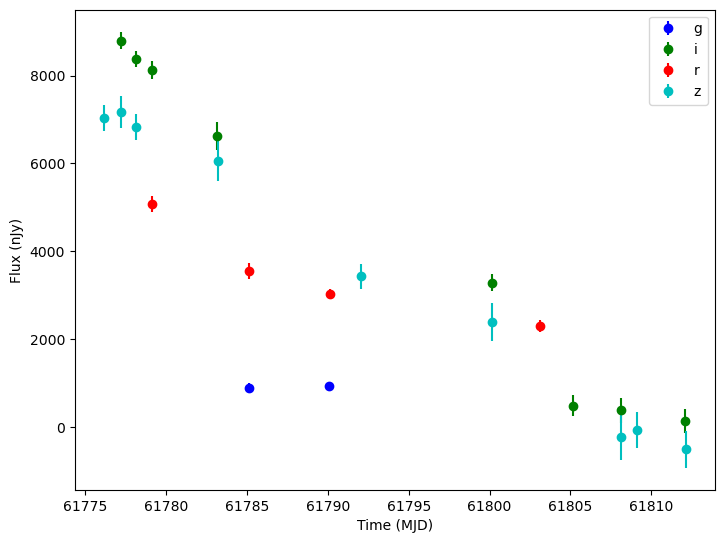

In [9]:
random_ids = np.random.choice(len(lightcurves), 10)

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.loc[random_id]

    if lc["nobs"] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
        )